# Deep-Learning with Keras on Amazon SageMaker with ANN from the Superdatascience course

See: https://www.superdatascience.com/courses/deep-learning-az

In [1]:
!pip install pydot

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Step 1: Download the data set 
The data sets are needed to train our Neural Network. We use the Churn_Modelling data set from the Superdatascience courses

In [2]:
!wget https://s3-ap-southeast-1.amazonaws.com/sgavinio-machine-learning-datasets/Churn_Modelling.csv

--2019-03-13 12:11:08--  https://s3-ap-southeast-1.amazonaws.com/sgavinio-machine-learning-datasets/Churn_Modelling.csv
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.32.105
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.32.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 684858 (669K) [text/csv]
Saving to: ‘Churn_Modelling.csv.1’

Churn_Modelling.csv 100%[===================>] 668.81K  --.-KB/s    in 0.01s   

2019-03-13 12:11:08 (60.5 MB/s) - ‘Churn_Modelling.csv.1’ saved [684858/684858]



## Step 2.1: Pre-process the data

Read the data set and encode categorical features.

In [2]:
# Start pre-processing template
import numpy as np
import pandas as pd

dataset = pd.read_csv("Churn_Modelling.csv")
features = dataset[[
        "CreditScore", 
        "Geography", 
        "Gender", 
        "Age", 
        "Tenure", 
        "Balance", 
        "NumOfProducts", 
        "HasCrCard", 
        "IsActiveMember", 
        "EstimatedSalary"
]]
output = dataset[["Exited"]]

# Convert dataframes to Arrays
X = features.values
y = output.values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode the categorical features: Gender and Geography
labelencoder_geography = LabelEncoder()
labelencoder_gender = LabelEncoder()
X[:, 1] = labelencoder_geography.fit_transform(X[:, 1])
X[:, 2] = labelencoder_gender.fit_transform(X[:, 2])
# We only one-hot-encode the geography, the age only has two values and will result in a dummy variable trap
# See n - 1 dummy variable rule
onehotencoder_geography = OneHotEncoder(categorical_features = [1])
X = onehotencoder_geography.fit_transform(X).toarray()
# We eliminate the first dummy variable from the geography: n - 1 dummy variable rule
X = X[:, 1:]

## Step 2.2: Split the data set into the training and test sets

In [3]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Step 2.3: Feature Scale the dependent variables

In [4]:
# Feature scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Step 3: Push the pre-processed data set to S3

Push the the processed train and test data sets to S3 such that they can be consumed easier during the training phase.

In [5]:
# if this produces an error, don't sweat it. Just means you already have the directory.
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [6]:
%%time

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
s3_bucket = sess.default_bucket()
s3_prefix = 'churn_modeling'

arn:aws:iam::572101368213:role/service-role/AmazonSageMaker-ExecutionRole-20181228T215310
CPU times: user 665 ms, sys: 80.9 ms, total: 746 ms
Wall time: 5.33 s


In [7]:
np.save('./data/train_X.npy', X_train)
np.save('./data/train_Y.npy', y_train)
np.save('./data/test_X.npy', X_test)
np.save('./data/test_Y.npy', y_test)

In [8]:
data_s3_prefix = '{}/data'.format(s3_prefix)

In [9]:
data_dir = sess.upload_data(path='./data/', bucket=s3_bucket, key_prefix=data_s3_prefix)

## Step 4: Build the Artificial Neural Network

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [11]:
def keras_model_fn(hyperparameters):
    # Define the layers
    classifier = Sequential()
    # relu is rectifier activation function
    # Dense is simple fully-connected layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu", input_dim = 11, name = "inputs"))
    # Second hidden layer, no need to define inpout_dim, this layer is automatically linked to the first layer
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation = "relu"))
    # Output layer
    classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid"))
    # Compile the ANN, configure back-propagation
    # adam is a type of stochastic gradient descent, binary_crossentropy is used for binary outputs
    classifier.compile(optimizer = hyperparameters["optimizer"], loss = "binary_crossentropy", metrics = ["accuracy"])

    return classifier

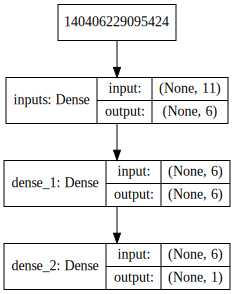

In [12]:
classifier=keras_model_fn({"optimizer": "adam"})
SVG(model_to_dot(classifier,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

## Step 5: Train on the notebook instance to verify

As a sanity check before launching a SageMaker training job, we train and evaluate the model on the notebook instance to check that all is well.

In [25]:
classifier.summary()
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 1)

test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (Dense)               (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8000/8000 [==============================] - 1s 148us/step - loss: 0.3989 - acc: 0.8356
Epoch 2/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3990 - acc: 0.8362
Epoch 3/100
8000/8000 [==============================] - 1s 147us/step - loss: 0.3992 - acc: 0.8349
Epoch 4/100
8000/8000 [==============================] - 1s 147us/step - loss: 0.3981 - acc: 0.8342
Epoch 5/

8000/8000 [==============================] - 1s 146us/step - loss: 0.3986 - acc: 0.8349
Epoch 76/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3987 - acc: 0.8349
Epoch 77/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3985 - acc: 0.8359
Epoch 78/100
8000/8000 [==============================] - 1s 149us/step - loss: 0.3981 - acc: 0.8367
Epoch 79/100
8000/8000 [==============================] - 1s 147us/step - loss: 0.3984 - acc: 0.8360
Epoch 80/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3987 - acc: 0.8362
Epoch 81/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3983 - acc: 0.8335
Epoch 82/100
8000/8000 [==============================] - 1s 147us/step - loss: 0.3984 - acc: 0.8360
Epoch 83/100
8000/8000 [==============================] - 1s 145us/step - loss: 0.3986 - acc: 0.8344
Epoch 84/100
8000/8000 [==============================] - 1s 146us/step - loss: 0.3988 - acc: 0.8357
Epo

## Step 6: Train as a SageMaker training job

The TensorFlow estimator uses the `keras_ann.py` script as the entrypoint. Give special attention to the `keras_model_fn` which was re-defined within this python script.

In [ ]:
from sagemaker.tensorflow import TensorFlow

BATCH_SIZE = 10

tf_estimator = TensorFlow(
    entry_point="keras_ann.py",
    role=role,
    framework_version="1.12.0",
    train_instance_count=1, 
    train_instance_type="ml.c4.xlarge",
    training_steps=8000/BATCH_SIZE, 
    evaluation_steps=2000/BATCH_SIZE,
    hyperparameters={'optimizer': 'adam'}
)
tf_estimator.fit(data_dir)

### Step 7: Deploy the ANN to SageMaker and expose as an endpoint

If we wish to deploy the model to production, the next step is to create a SageMaker hosted endpoint. The endpoint will retrieve the TensorFlow SavedModel created during training and deploy it within a TensorFlow Serving container. This all can be accomplished with one line of code, an invocation of the Estimator's deploy method.

In [42]:
predictor = tf_estimator.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-2019-03-17-06-57-12-441
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-2019-03-17-06-57-12-441


----------------------------------------------------------------------------!

### Step 8: Make some Predictions
Predict if customer with following information will leave the bank or not:

* Geography: France, Credit Score: 600, Gender: Male, Age: 40, Tenure: 3
* Balance:  60000, Number of Products: 2, Has Credit Card: Yes
* Is Active Member: yes, Estimated Salary: 50000
Alternatively, you may also make invocations by hitting the HTTPS endpoint or using the sagemaker CLI

In [47]:
# Feature scale using the standard scaler that has been fitted to the dataset already
observation = sc.transform(np.array([[0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000.0]]))

# The inputs key 'inputs_input' matches the Keras InputLayer name
predictor.predict({'inputs_input': observation})

{'outputs': {'dense_1': {'dtype': 1,
   'tensor_shape': {'dim': [{'size': 1}, {'size': 1}]},
   'float_val': [0.08183988928794861]}},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1552805984},
  'signature_name': 'serving_default'}}

### Optional: Train using TensorFlow ScriptMode

The above SageMaker training invocation executes the training and validation using the TensorFlow Legacy mode. To run using the newer ScriptMode, execute the following cell instead.

Because you have flexibility of how to perform training and validation when running in ScriptMode, it easier to configure the hyperparameters such as the batch_size and epochs.

See: https://docs.aws.amazon.com/sagemaker/latest/dg/tf.html

In [49]:
# Based-off: https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/keras-embeddings-script-mode/keras-embeddings.ipynb

from sagemaker.tensorflow import TensorFlow

tf_estimator_sm = TensorFlow(
    entry_point="keras_ann_script_mode.py",
    role=role,
    
    framework_version="1.12.0",
    train_instance_count=1, 
    train_instance_type="ml.c4.xlarge",
    hyperparameters={'learning_rate': 0.1, 
                     'epochs': 100, 
                     'batch_size': 10},
    script_mode=True
)

tf_estimator_sm.fit({'train': data_dir, 'eval': data_dir})

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-03-17-07-31-02-392


2019-03-17 07:31:04 Starting - Starting the training job...
2019-03-17 07:31:12 Starting - Launching requested ML instances......
2019-03-17 07:32:18 Starting - Preparing the instances for training...
2019-03-17 07:32:57 Downloading - Downloading input data...
2019-03-17 07:33:18 Training - Training image download completed. Training in progress.
2019-03-17 07:33:21,136 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-03-17 07:33:21,143 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-17 07:33:21,529 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-17 07:33:21,546 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-17 07:33:21,556 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "module_dir": "s3://sagemaker-ap-southeast-1-572101368213/sagemaker-tensorflow-scriptmode-2019-03-17-07-31-02-392/source/sourcedir.tar.gz"

#015  10/8000 [..............................] - ETA: 1s - loss: 0.4419 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 330/8000 [>.............................] - ETA: 1s - loss: 0.3838 - acc: 0.8061#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 650/8000 [=>............................] - ETA: 1s - loss: 0.3813 - acc: 0.8031#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.5057 - acc: 0.7000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.4867 - acc: 0.7438#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 620/8000 [=>............................] - ETA: 1s - loss: 0.4566 - acc: 0.7742#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.5453 - acc: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 310/8000 [>.............................] - ETA: 1s - loss: 0.4812 - acc: 0.7871#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 630/8000 [=>............................] - ETA: 1s - loss: 0.4475 - acc: 0.8048#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.6219 - acc: 0.7000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  90/8000 [..............................] - ETA: 4s - loss: 0.4582 - acc: 0.7556#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 280/8000 [>.............................] - ETA: 2s - loss: 0.4263 - acc: 0.8071#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.2135 - acc: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 340/8000 [>.............................] - ETA: 1s - loss: 0.4140 - acc: 0.8235#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 670/8000 [=>............................] - ETA: 1s - loss: 0.3956 - acc: 0.8149#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.5284 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 340/8000 [>.............................] - ETA: 1s - loss: 0.4862 - acc: 0.7676#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 660/8000 [=>............................] - ETA: 1s - loss: 0.4547 - acc: 0.7818#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.3956 - acc: 0.7000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.4574 - acc: 0.7750#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 640/8000 [=>............................] - ETA: 1s - loss: 0.4835 - acc: 0.7687#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 2s - loss: 0.3250 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 340/8000 [>.............................] - ETA: 1s - loss: 0.4493 - acc: 0.7765#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 650/8000 [=>............................] - ETA: 1s - loss: 0.4489 - acc: 0.7769#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.2405 - acc: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 320/8000 [>.............................] - ETA: 1s - loss: 0.3699 - acc: 0.8281#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 630/8000 [=>............................] - ETA: 1s - loss: 0.3953 - acc: 0.8048#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.1512 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 310/8000 [>.............................] - ETA: 1s - loss: 0.3444 - acc: 0.8484#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 620/8000 [=>............................] - ETA: 1s - loss: 0.3936 - acc: 0.8177#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 1s - loss: 0.3087 - acc: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 300/8000 [>.............................] - ETA: 1s - loss: 0.4269 - acc: 0.8100#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 600/8000 [=>............................] - ETA: 1s - loss: 0.4342 - acc: 0.8050#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015  10/8000 [..............................] - ETA: 2s - loss: 0.2511 - acc: 0.9000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 310/8000 [>.............................] - ETA: 1s - loss: 0.4785 - acc: 0.8032#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 600/8000 [=>............................] - ETA: 1s - loss: 0.4726 - acc: 0.7983#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

2019-03-17 07:35:42,788 sagemaker-containers INFO     Reporting training SUCCESS

2019-03-17 07:35:52 Uploading - Uploading generated training model
2019-03-17 07:35:52 Completed - Training job completed
Billable seconds: 175


In [50]:
predictor_sm = tf_estimator_sm.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-03-17-07-31-02-392
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-03-17-07-31-02-392


---------------------------------------------------------------!

In [53]:
# TensorFlow serving in this case expects single observation as a 1-D array
predictor_sm.predict({'inputs_input': observation[0]})

{'predictions': [[0.10314]]}

### Step 9: Cleaning-up

To avoid incurring charges to your AWS account for the resources used you need to delete the SageMaker Endpoint.

*Note: If you've re-run the deployment multiple, you will have multiple endpoints to clean-up. Clean this up manually by going to the SageMaker console.*

In [54]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-2019-03-17-06-57-12-441


If you deployed the script mode model make sure to clean it up as well.

In [55]:
sagemaker.Session().delete_endpoint(predictor_sm.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2019-03-17-07-31-02-392
